<a href="https://colab.research.google.com/github/ahmedhamodien/Machine-Learning-/blob/main/MLProjectResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# تحميل بيانات المشروع من GitHub
!git clone https://github.com/chandrikadeb7/Face-Mask-Detection.git
import os

# التأكد من وجود المجلدات
data_path = 'Face-Mask-Detection/dataset'
print(os.listdir(data_path))


fatal: destination path 'Face-Mask-Detection' already exists and is not an empty directory.
['with_mask', 'without_mask']


In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Load model
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/face_mask_model_resnet50.h5'
model = load_model(model_path)
print("✅ Model loaded successfully!")

# 3. Any other code you need (like Gradio or testing)


import gradio as gr
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

img_size = 224  # خليها نفس الحجم اللي استخدمته أثناء التدريب

def predict_image(img):
    img = img.resize((img_size, img_size))
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    prediction = model.predict(img_array)[0][0]
    label = "With Mask" if prediction < 0.5 else "Without Mask"
    return label, img

demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(), gr.Image(type="pil")],
    title="Face Mask Detection (ResNet50)"
)

demo.launch(share=True)


Mounted at /content/drive


✅ Model loaded successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6eb1c84cc07039a1d8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Load model
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/face_mask_model_resnet50.h5'
model = load_model(model_path)
print("✅ Model loaded successfully!")

# 3. Any other code you need (like Gradio or testing)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model loaded successfully!


In [ ]:
# ✅ 2. Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import gradio as gr
from PIL import Image

In [ ]:
# ✅ 3. Set Paths
base_dir = "/content/Face-Mask-Detection/dataset"
with_mask_path = os.path.join(base_dir, 'with_mask')
without_mask_path = os.path.join(base_dir, 'without_mask')

# ✅ 4. Count Images
with_mask_count = len(os.listdir(with_mask_path))
without_mask_count = len(os.listdir(without_mask_path))
print(f"with_mask: {with_mask_count} images")
print(f"without_mask: {without_mask_count} images")

with_mask: 2165 images
without_mask: 1930 images


In [ ]:
# ✅ 5. Data Generators
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 3274 images belonging to 2 classes.
Found 818 images belonging to 2 classes.


In [ ]:
# ✅ 6. Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.946242774566474), 1: np.float64(1.0602331606217616)}


In [ ]:
# ✅ 7. Build Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ✅ 8. Initial Training
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_resnet_model.h5", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 66/103 ━━━━━━━━━━━━━━━━━━━━ 3:10 5s/step - accuracy: 0.8701 - loss: 0.2910

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9013 - loss: 0.2231

103/103 ━━━━━━━━━━━━━━━━━━━━ 680s 7s/step - accuracy: 0.9019 - loss: 0.2218 - val_accuracy: 0.9976 - val_loss: 0.0092
Epoch 2/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 667s 6s/step - accuracy: 0.9962 - loss: 0.0143 - val_accuracy: 0.9927 - val_loss: 0.0302
Epoch 3/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 675s 6s/step - accuracy: 0.9952 - loss: 0.0154 - val_accuracy: 0.9951 - val_loss: 0.0246
Epoch 4/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 660s 6s/step - accuracy: 0.9934 - loss: 0.0194 - val_accuracy: 0.9963 - val_loss: 0.0099
Epoch 5/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.9884 - loss: 0.0325 - val_accuracy: 0.9890 - val_loss: 0.0347
Epoch 6/20
103/103 ━━━━━━━━━━━━━━━━━━━━ 665s 6s/step - accuracy: 0.9955 - loss: 0.0149 - val_accuracy: 0.9902 - val_loss: 0.0293


In [ ]:
# ✅ 9. Fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9732 - loss: 0.0729

103/103 ━━━━━━━━━━━━━━━━━━━━ 944s 9s/step - accuracy: 0.9733 - loss: 0.0727 - val_accuracy: 0.9976 - val_loss: 0.0089
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 979s 9s/step - accuracy: 0.9947 - loss: 0.0175 - val_accuracy: 0.9963 - val_loss: 0.0091
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9984 - loss: 0.0091

103/103 ━━━━━━━━━━━━━━━━━━━━ 968s 9s/step - accuracy: 0.9984 - loss: 0.0091 - val_accuracy: 0.9988 - val_loss: 0.0077
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9996 - loss: 0.0053

103/103 ━━━━━━━━━━━━━━━━━━━━ 918s 9s/step - accuracy: 0.9996 - loss: 0.0054 - val_accuracy: 0.9988 - val_loss: 0.0058
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9997 - loss: 0.0044

103/103 ━━━━━━━━━━━━━━━━━━━━ 924s 9s/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 910s 9s/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9988 - val_loss: 0.0055
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 921s 9s/step - accuracy: 0.9983 - loss: 0.0041 - val_accuracy: 0.9988 - val_loss: 0.0054
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 1.0000 - loss: 0.0013

103/103 ━━━━━━━━━━━━━━━━━━━━ 913s 9s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9988 - val_loss: 0.0050
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9996 - loss: 0.0019

103/103 ━━━━━━━━━━━━━━━━━━━━ 912s 9s/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9988 - val_loss: 0.0043
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 906s 9s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9988 - val_loss: 0.0047


26/26 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       432
           1       1.00      1.00      1.00       386

    accuracy                           1.00       818
   macro avg       1.00      1.00      1.00       818
weighted avg       1.00      1.00      1.00       818



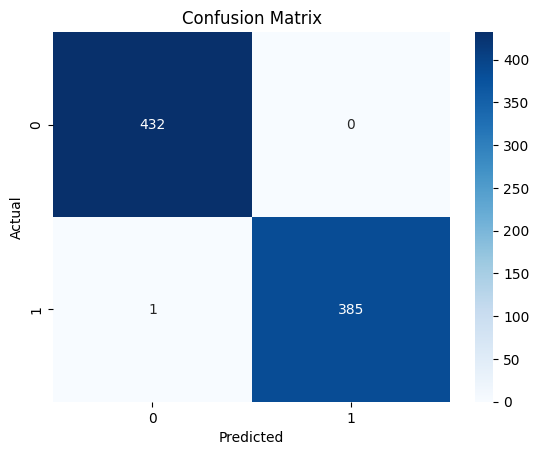

In [ ]:
# ✅ 10. Evaluation
val_gen.reset()
y_true = val_gen.classes
y_pred = (model.predict(val_gen) > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# ✅ 11. Gradio Interface
def predict_image(img):
    img = img.resize((img_size, img_size))
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    prediction = model.predict(img_array)[0][0]
    label = "With Mask" if prediction < 0.5 else "Without Mask"
    return label, img

demo = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Label(), gr.Image(type="pil")],
    title="Face Mask Detection (ResNet50 Optimized)"
)

demo.launch(share=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Load model
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/face_mask_model_resnet50.h5'
model = load_model(model_path)
print("✅ Model loaded successfully!")

# 3. Any other code you need (like Gradio or testing)


In [ ]:
# تأكد إن اسم الملف ده مناسبك
model_path = '/content/drive/MyDrive/face_mask_model_resnet50.h5'

# حفظ الموديل
model.save(model_path)
print(f"✅ Model saved to: {model_path}")


✅ Model saved to: /content/drive/MyDrive/face_mask_model_resnet50.h5


In [ ]:
model.save("face_mask_model.h5")


In [ ]:
from google.colab import files
files.download("face_mask_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>